# Лабораторная работа № 8 – Проведение исследований моделями обнаружения и распознавания объектов

## 1. Выбор начальных условий

Открытый датасет “Pothole Detection” с Kaggle — 665 изображений дорог с разметкой ям в формате PASCAL VOC.

Практическая мотивация — своевременное обнаружение дефектов покрытия повышает безопасность движения и экономит бюджет на ремонт.

Датасет: <>

### Метрики

* mAP@0.5 — основная метрика конкурса YOLO, отражает долю верных детекций при IoU ≥ 0.5.
* mAP@0.5:0.95 — усреднённая по порогам IoU, чувствительнее к точности локализации.
* Precision/Recall — позволяют увидеть баланс между ложно‑положительными и пропущенными объектами.


In [ ]:
!pip install -q ultralytics opencv-python matplotlib albumentations

In [ ]:
import os
os.environ["KAGGLE_USERNAME"] = "ebumba"
os.environ["KAGGLE_KEY"] = "xd"

In [ ]:
import os, subprocess, pathlib, zipfile, shutil

DATA_DIR = pathlib.Path('data/pothole')
if not DATA_DIR.exists():
    DATA_DIR.mkdir(parents=True, exist_ok=True)

!kaggle datasets download -d andrewmvd/pothole-detection -p $DATA_DIR --force

zip_path = DATA_DIR/'pothole-detection.zip'
if zip_path.exists():
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(DATA_DIR)
    zip_path.unlink()

import glob, pprint
imgs = glob.glob(str(DATA_DIR/'*/*.jpg')) + glob.glob(str(DATA_DIR/'*/*.png'))
print(f'Всего изображений: {len(imgs)}')

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/pothole-detection
License(s): other
 95% 318M/334M [00:01<00:00, 316MB/s]
100% 334M/334M [00:01<00:00, 290MB/s]
Всего изображений: 665


### Подготовка датасета к формату YOLOv8

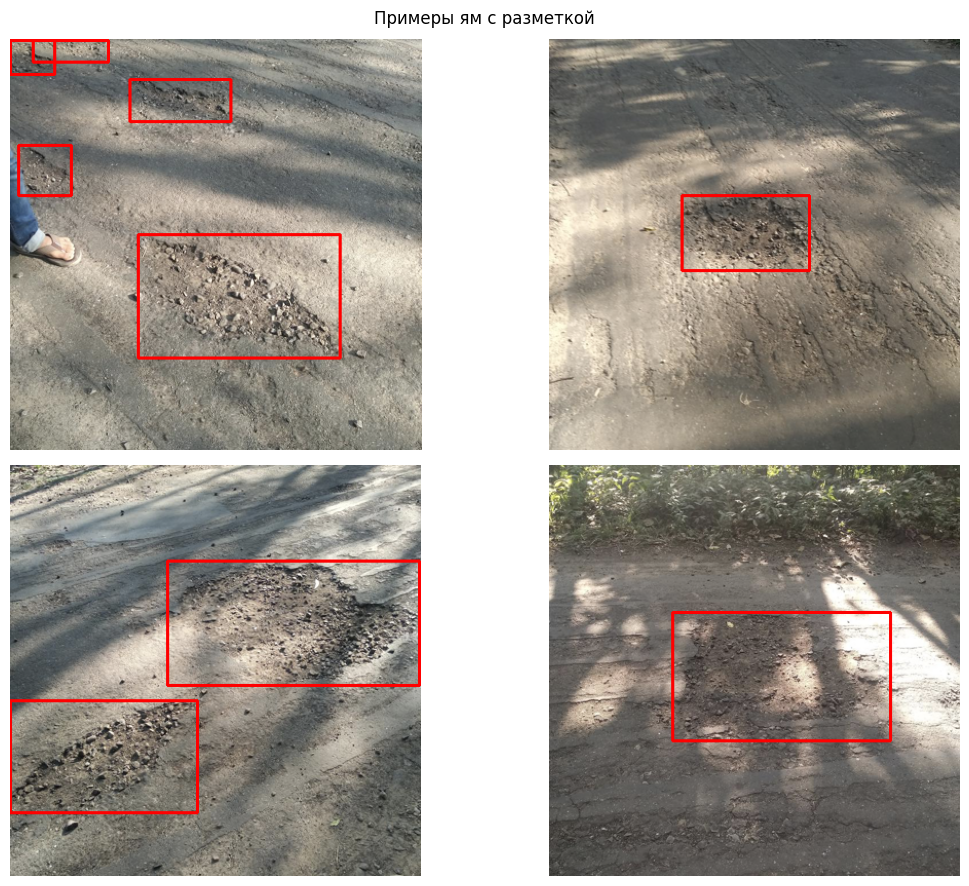

In [ ]:
import cv2, random, matplotlib.pyplot as plt, xml.etree.ElementTree as ET, pathlib

def draw_bbox(xml_path):
    tree = ET.parse(str(xml_path))
    root = tree.getroot()
    filename = root.find('filename').text
    img_path = xml_path.parent.parent / 'images' / filename

    img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
    for obj in root.findall('object'):
        bnd = obj.find('bndbox')
        xmin, ymin, xmax, ymax = [int(float(bnd.find(t).text)) for t in ['xmin','ymin','xmax','ymax']]
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
    return img

annos = list(pathlib.Path('data/pothole/annotations').glob('*.xml'))
plt.figure(figsize=(12, 9))
for i, xml_path in enumerate(random.sample(annos, 4), 1):
    plt.subplot(2, 2, i)
    plt.imshow(draw_bbox(xml_path)); plt.axis('off')
plt.suptitle('Примеры ям с разметкой'); plt.tight_layout()

In [ ]:
import pathlib, random, shutil, yaml, xml.etree.ElementTree as ET

ROOT = pathlib.Path('data/pothole').resolve()

xml_files = list((ROOT / 'annotations').glob('*.xml'))
random.shuffle(xml_files)
n = len(xml_files)

splits_xml = {
    'train': xml_files[: int(0.7 * n)],
    'val':   xml_files[int(0.7 * n) : int(0.85 * n)],
    'test':  xml_files[int(0.85 * n):]
}

for split, xml_list in splits_xml.items():
    img_dir   = ROOT / split / 'images'
    label_dir = ROOT / split / 'labels'
    img_dir.mkdir(parents=True, exist_ok=True)
    label_dir.mkdir(parents=True, exist_ok=True)

    for xml_path in xml_list:
        tree = ET.parse(xml_path)
        root = tree.getroot()

        filename = root.find('filename').text
        img_path = xml_path.parent.parent / 'images' / filename

        shutil.copy(img_path, img_dir / filename)

        size = root.find('size')
        w, h = int(size.find('width').text), int(size.find('height').text)
        yolo_lines = []
        for obj in root.findall('object'):
            bnd = obj.find('bndbox')
            xmin, ymin, xmax, ymax = [int(float(bnd.find(t).text)) for t in ('xmin','ymin','xmax','ymax')]
            x_c = (xmin + xmax) / 2 / w
            y_c = (ymin + ymax) / 2 / h
            bw  = (xmax - xmin) / w
            bh  = (ymax - ymin) / h
            yolo_lines.append(f"0 {x_c:.6f} {y_c:.6f} {bw:.6f} {bh:.6f}")

        with open(label_dir / f"{xml_path.stem}.txt", "w") as f:
            f.write("\n".join(yolo_lines))

data_yaml = {
    'path': str(ROOT),
    'train': 'train/images',
    'val':   'val/images',
    'test':  'test/images',
    'nc': 1,
    'names': ['pothole']
}
with open('pothole.yaml', 'w') as f:
    yaml.dump(data_yaml, f, sort_keys=False)

## 2. Бейзлайн: YOLOv8‑nano (предобученная на COCO)

In [ ]:
from ultralytics import YOLO
model = YOLO('yolov8n.pt')
results = model.train(data='pothole.yaml', epochs=50, imgsz=640, project='runs_pothole', name='baseline', batch=-1)

metrics = model.val(data='pothole.yaml', split='test')
print(metrics)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 262MB/s]


Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=pothole.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=baseline, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profil

100%|██████████| 755k/755k [00:00<00:00, 128MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,043 parameters, 3,011,027 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 395MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2931.7±1463.9 MB/s, size: 619.3 KB)


train: Scanning /content/data/pothole/train/labels... 465 images, 0 backgrounds, 0 corrupt: 100%|██████████| 465/465 [00:00<00:00, 873.78it/s]

train: New cache created: /content/data/pothole/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla T4) 14.74G total, 0.10G reserved, 0.08G allocated, 14.56G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     3011043       8.194         0.386         35.38         236.2        (1, 3, 640, 640)                    list
     3011043       16.39         0.533         20.27         77.61        (2, 3, 640, 640)                    list
     3011043       32.78         0.860         23.83            73        (4, 3, 640, 640)                    list
     3011043       65.55         1.447         30.17         95.03        (8, 3, 640, 640)                    list
     3011043       131.1         2.

train: Scanning /content/data/pothole/train/labels.cache... 465 images, 0 backgrounds, 0 corrupt: 100%|██████████| 465/465 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2117.6±1349.0 MB/s, size: 478.9 KB)


val: Scanning /content/data/pothole/val/labels... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<00:00, 554.17it/s]

val: New cache created: /content/data/pothole/val/labels.cache


Plotting labels to runs_pothole/baseline/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00046875), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs_pothole/baseline
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      7.27G      1.852        3.4      1.694        182        640: 100%|██████████| 8/8 [00:10<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.27s/it]

                   all        100        273    0.00483      0.531     0.0851     0.0319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      7.03G      1.566      2.701      1.467        220        640: 100%|██████████| 8/8 [00:05<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

                   all        100        273    0.00757      0.832      0.283      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      7.19G      1.409      1.947      1.382        195        640: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

                   all        100        273      0.467      0.366      0.322       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      7.24G      1.422      1.721       1.34        196        640: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

                   all        100        273      0.924     0.0888      0.391      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      7.03G      1.368      1.596      1.295        194        640: 100%|██████████| 8/8 [00:04<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.60s/it]

                   all        100        273      0.849      0.114      0.254      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      7.03G      1.376      1.596      1.305        219        640: 100%|██████████| 8/8 [00:04<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

                   all        100        273      0.687      0.161      0.288      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      7.14G      1.375      1.537      1.315        212        640: 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

                   all        100        273        0.3      0.136      0.117     0.0483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      7.12G      1.341      1.507      1.296        196        640: 100%|██████████| 8/8 [00:04<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.87s/it]

                   all        100        273      0.163     0.0593     0.0411     0.0176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      7.22G      1.381      1.461      1.306        202        640: 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]

                   all        100        273      0.448      0.253       0.24      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      7.13G      1.387      1.446      1.315        176        640: 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

                   all        100        273      0.237      0.216      0.156     0.0682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      7.03G      1.376      1.422      1.317        208        640: 100%|██████████| 8/8 [00:04<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]

                   all        100        273      0.125     0.0916     0.0492     0.0198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      7.14G      1.388      1.413      1.318        179        640: 100%|██████████| 8/8 [00:05<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

                   all        100        273      0.131     0.0916     0.0389     0.0174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      7.12G       1.36      1.389      1.314        198        640: 100%|██████████| 8/8 [00:05<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

                   all        100        273      0.301      0.242      0.204     0.0924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      7.14G      1.409       1.37      1.319        211        640: 100%|██████████| 8/8 [00:05<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]

                   all        100        273      0.254      0.139      0.122     0.0557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      7.14G      1.352      1.273       1.31        201        640: 100%|██████████| 8/8 [00:05<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

                   all        100        273       0.39      0.315       0.29      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      7.14G      1.355      1.278      1.277        190        640: 100%|██████████| 8/8 [00:06<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

                   all        100        273      0.287      0.313      0.249      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      7.14G      1.304      1.222      1.278        183        640: 100%|██████████| 8/8 [00:05<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.19s/it]

                   all        100        273       0.52      0.465      0.471      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      7.26G      1.305        1.2       1.28        191        640: 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

                   all        100        273      0.508      0.465      0.458      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      7.11G       1.29      1.154      1.253        255        640: 100%|██████████| 8/8 [00:05<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

                   all        100        273      0.521      0.399      0.428       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      7.15G      1.293      1.169      1.267        216        640: 100%|██████████| 8/8 [00:05<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]

                   all        100        273      0.552      0.469      0.499      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      7.11G      1.256      1.117      1.247        210        640: 100%|██████████| 8/8 [00:06<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

                   all        100        273      0.597      0.521      0.545      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      7.12G      1.289      1.116      1.245        194        640: 100%|██████████| 8/8 [00:06<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

                   all        100        273      0.614      0.472      0.542        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      7.15G      1.231      1.095      1.232        223        640: 100%|██████████| 8/8 [00:05<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]

                   all        100        273      0.662      0.557      0.588      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      7.11G      1.211      1.053      1.214        267        640: 100%|██████████| 8/8 [00:05<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

                   all        100        273       0.62      0.524      0.538      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.11G      1.195       1.02      1.211        206        640: 100%|██████████| 8/8 [00:06<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

                   all        100        273      0.504      0.569      0.524       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      7.14G      1.197      1.008      1.201        218        640: 100%|██████████| 8/8 [00:05<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]

                   all        100        273       0.68      0.637      0.672       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      7.11G      1.177     0.9686      1.184        199        640: 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]

                   all        100        273      0.615       0.52      0.565      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50       7.1G      1.168     0.9683      1.186        224        640: 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

                   all        100        273      0.724      0.546      0.631      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      7.11G      1.145     0.9371      1.169        231        640: 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

                   all        100        273       0.75      0.615      0.721      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      7.15G      1.125     0.9063      1.154        192        640: 100%|██████████| 8/8 [00:04<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]

                   all        100        273      0.728      0.604      0.696      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      7.14G      1.134     0.9157       1.17        224        640: 100%|██████████| 8/8 [00:05<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

                   all        100        273      0.685      0.593      0.665      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      7.11G       1.13     0.9008      1.166        192        640: 100%|██████████| 8/8 [00:05<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

                   all        100        273      0.751      0.623      0.708      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      7.12G       1.11     0.8705      1.153        213        640: 100%|██████████| 8/8 [00:05<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

                   all        100        273      0.621      0.711      0.717      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      7.12G      1.068     0.8407      1.129        157        640: 100%|██████████| 8/8 [00:05<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

                   all        100        273      0.712      0.643      0.703      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50       7.2G      1.074     0.8283      1.123        242        640: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

                   all        100        273      0.775      0.604      0.713      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      7.14G       1.07     0.8287      1.135        194        640: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.84s/it]

                   all        100        273      0.825      0.557       0.68      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      7.11G      1.029     0.7955      1.106        210        640: 100%|██████████| 8/8 [00:05<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

                   all        100        273      0.811      0.596      0.734       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      7.15G       1.04     0.7772      1.101        251        640: 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

                   all        100        273      0.813      0.645      0.742      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      7.12G       1.02     0.7722      1.104        197        640: 100%|██████████| 8/8 [00:06<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

                   all        100        273      0.847      0.593      0.721      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      7.12G      1.015     0.7627      1.102        233        640: 100%|██████████| 8/8 [00:05<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

                   all        100        273      0.814      0.637      0.753      0.487


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      7.13G     0.9597     0.7771      1.059         99        640: 100%|██████████| 8/8 [00:14<00:00,  1.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

                   all        100        273      0.723      0.593      0.689      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      7.14G     0.9415      0.701      1.047        124        640: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

                   all        100        273      0.757      0.604      0.691       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50       7.1G     0.9134     0.6548       1.03        109        640: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

                   all        100        273      0.739      0.626      0.728      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      7.07G     0.8902     0.6237      1.025         97        640: 100%|██████████| 8/8 [00:07<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

                   all        100        273      0.792      0.641      0.741      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      7.12G     0.8658     0.6096      1.005        133        640: 100%|██████████| 8/8 [00:05<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

                   all        100        273      0.832      0.597      0.734      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      7.11G     0.8457     0.5964      0.998        120        640: 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]

                   all        100        273      0.813      0.652      0.784      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      7.11G     0.8676     0.6036      1.011        106        640: 100%|██████████| 8/8 [00:04<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

                   all        100        273      0.824      0.637      0.782      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      7.03G     0.8291     0.5566     0.9908        103        640: 100%|██████████| 8/8 [00:05<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

                   all        100        273      0.837      0.657      0.784      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      7.12G     0.8239     0.5685       0.99        116        640: 100%|██████████| 8/8 [00:04<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]

                   all        100        273      0.824      0.641      0.782      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      7.09G     0.8202     0.5585     0.9895        120        640: 100%|██████████| 8/8 [00:04<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

                   all        100        273      0.854       0.63      0.783      0.521



50 epochs completed in 0.129 hours.
Optimizer stripped from runs_pothole/baseline/weights/last.pt, 6.2MB
Optimizer stripped from runs_pothole/baseline/weights/best.pt, 6.2MB

Validating runs_pothole/baseline/weights/best.pt...
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


                   all        100        273      0.848      0.632      0.783      0.522
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs_pothole/baseline
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3041.8±960.0 MB/s, size: 476.0 KB)


val: Scanning /content/data/pothole/test/labels... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<00:00, 861.83it/s]

val: New cache created: /content/data/pothole/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.16s/it]


                   all        100        275      0.737      0.716      0.772        0.5
Speed: 6.6ms preprocess, 5.1ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs_pothole/baseline2
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7bc9101dd850>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0

## 3. Улучшение бейзлайна
Гипотезы:
1. Увеличение размера входа до 800x800.
2. Использование более ёмкой модели yolov8m.
3. Включение расширенных аугментаций: mosaic, mixup* переключение hue-saturation-value.
4. Тонкий подбор lr0 и weight_decay через встроенный оптимизатор конфигов Ultralytics.

In [ ]:
model_m = YOLO('yolov8m.pt')
results_m = model_m.train(
    data='pothole.yaml',
    epochs=100,
    imgsz=800,
    project='runs_pothole',
    name='improved',
    batch=-1,
    hsv_h=0.015,hsv_s=0.7,hsv_v=0.4,
    mosaic=1.0,
    mixup=0.2,
    lr0=0.01,
    weight_decay=0.0005
)

100%|██████████| 49.7M/49.7M [00:01<00:00, 47.5MB/s]


Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=pothole.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=800, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=improved, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profi

train: Scanning /content/data/pothole/train/labels.cache... 465 images, 0 backgrounds, 0 corrupt: 100%|██████████| 465/465 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
AutoBatch: Computing optimal batch size for imgsz=800 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla T4) 14.74G total, 2.39G reserved, 0.28G allocated, 12.06G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output


    25856899       123.5         2.154         35.88         97.11        (1, 3, 800, 800)                    list
    25856899       247.1         2.888         46.26         115.2        (2, 3, 800, 800)                    list
    25856899       494.2         4.370         67.15         133.9        (4, 3, 800, 800)                    list
    25856899       988.3         6.977         128.8         231.9        (8, 3, 800, 800)                    list
    25856899        1977        12.247         258.8         440.3       (16, 3, 800, 800)                    list
AutoBatch: Using batch-size 8 for CUDA:0 9.61G/14.74G (65%) ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2573.7±1000.4 MB/s, size: 404.6 KB)


train: Scanning /content/data/pothole/train/labels.cache... 465 images, 0 backgrounds, 0 corrupt: 100%|██████████| 465/465 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1551.2±1183.8 MB/s, size: 478.9 KB)


val: Scanning /content/data/pothole/val/labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]


Plotting labels to runs_pothole/improved/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 800 train, 800 val
Using 2 dataloader workers
Logging results to runs_pothole/improved
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      5.01G      1.815      2.699      1.801          3        800: 100%|██████████| 59/59 [00:26<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.30it/s]

                   all        100        273     0.0866      0.275     0.0653     0.0257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      6.19G      1.823      2.302      1.853          6        800: 100%|██████████| 59/59 [00:25<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.17it/s]

                   all        100        273   0.000333     0.0366   0.000173   8.74e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      6.19G       1.91      2.417      1.922         12        800: 100%|██████████| 59/59 [00:25<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.53it/s]

                   all        100        273    0.00664     0.0916    0.00274   0.000849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      6.26G      1.908      2.246      1.876         10        800: 100%|██████████| 59/59 [00:25<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.51it/s]

                   all        100        273    0.00647       0.19    0.00351    0.00126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      6.26G      1.868      2.223      1.899          1        800: 100%|██████████| 59/59 [00:25<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.22it/s]

                   all        100        273      0.206      0.238      0.103      0.038



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      6.26G      1.882      2.145      1.854          2        800: 100%|██████████| 59/59 [00:25<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.02it/s]

                   all        100        273      0.446       0.41      0.389      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      6.26G      1.835       2.19      1.855         15        800: 100%|██████████| 59/59 [00:25<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.14it/s]

                   all        100        273      0.328      0.365      0.304      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      6.26G      1.731      1.991       1.74          1        800: 100%|██████████| 59/59 [00:25<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.72it/s]

                   all        100        273      0.516      0.418      0.422       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      6.26G      1.746      1.982      1.794          9        800: 100%|██████████| 59/59 [00:25<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]

                   all        100        273      0.574      0.337      0.406      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      6.31G      1.721      1.905      1.735          7        800: 100%|██████████| 59/59 [00:32<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.51it/s]

                   all        100        273      0.519      0.503      0.515      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      6.39G      1.726      1.894      1.729          3        800: 100%|██████████| 59/59 [00:25<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.52it/s]

                   all        100        273      0.562      0.505       0.53      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      6.45G      1.627      1.817      1.691          2        800: 100%|██████████| 59/59 [00:25<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.62it/s]

                   all        100        273      0.611      0.429      0.476      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      6.46G       1.64       1.81      1.697          3        800: 100%|██████████| 59/59 [00:25<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.73it/s]

                   all        100        273      0.738      0.392      0.522      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      6.46G      1.641      1.768      1.667         17        800: 100%|██████████| 59/59 [00:25<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]

                   all        100        273       0.59      0.495      0.527      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      6.46G      1.581      1.714      1.607          6        800: 100%|██████████| 59/59 [00:25<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.43it/s]

                   all        100        273      0.664      0.522      0.596      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      6.46G      1.584      1.705       1.64          4        800: 100%|██████████| 59/59 [00:25<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.59it/s]

                   all        100        273      0.629      0.454      0.496      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      6.46G      1.525       1.63      1.592          5        800: 100%|██████████| 59/59 [00:26<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.30it/s]

                   all        100        273       0.57      0.502      0.569      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      6.51G      1.563      1.651      1.615          8        800: 100%|██████████| 59/59 [00:25<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.55it/s]

                   all        100        273      0.663      0.531      0.621      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      6.51G      1.522       1.65      1.603          3        800: 100%|██████████| 59/59 [00:26<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.03it/s]

                   all        100        273      0.715      0.506      0.613      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      6.51G      1.523      1.624      1.597         11        800: 100%|██████████| 59/59 [00:25<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]

                   all        100        273      0.658      0.586      0.644      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      6.51G      1.522      1.633      1.602          2        800: 100%|██████████| 59/59 [00:27<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.59it/s]

                   all        100        273      0.765      0.505      0.631      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      6.51G      1.559      1.636      1.615         10        800: 100%|██████████| 59/59 [00:25<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.49it/s]

                   all        100        273      0.675      0.579      0.654      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      6.51G      1.511      1.618      1.581          9        800: 100%|██████████| 59/59 [00:25<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

                   all        100        273      0.728      0.527      0.617      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      6.51G      1.491      1.578      1.573          5        800: 100%|██████████| 59/59 [00:25<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.00it/s]

                   all        100        273      0.678      0.554       0.65      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      6.51G       1.48      1.551      1.569         10        800: 100%|██████████| 59/59 [00:25<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.56it/s]

                   all        100        273      0.649       0.63      0.663      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      6.51G      1.442      1.472      1.538          3        800: 100%|██████████| 59/59 [00:25<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.14it/s]

                   all        100        273      0.698      0.531      0.615      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      6.53G       1.43      1.414      1.519         12        800: 100%|██████████| 59/59 [00:25<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.44it/s]

                   all        100        273      0.721       0.55       0.66       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      6.53G      1.414       1.45      1.516          2        800: 100%|██████████| 59/59 [00:25<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.53it/s]

                   all        100        273      0.758      0.609      0.707      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      6.53G      1.406       1.41      1.526          4        800: 100%|██████████| 59/59 [00:24<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.36it/s]

                   all        100        273      0.728       0.59      0.701      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      6.53G      1.446      1.473       1.55          2        800: 100%|██████████| 59/59 [00:25<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.46it/s]

                   all        100        273      0.661      0.629      0.675      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      6.53G      1.424      1.465      1.539          6        800: 100%|██████████| 59/59 [00:25<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]

                   all        100        273      0.732      0.591      0.683      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      6.53G      1.372      1.334      1.484          8        800: 100%|██████████| 59/59 [00:24<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]

                   all        100        273       0.62      0.612      0.661      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      6.53G      1.373      1.359      1.492          6        800: 100%|██████████| 59/59 [00:25<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.49it/s]

                   all        100        273      0.713      0.608      0.698      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      6.53G      1.387      1.399      1.493          3        800: 100%|██████████| 59/59 [00:25<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.46it/s]

                   all        100        273      0.731      0.582      0.674       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      6.53G       1.34      1.314      1.468          4        800: 100%|██████████| 59/59 [00:25<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.12it/s]

                   all        100        273        0.7       0.67       0.72      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      6.53G      1.355      1.357      1.475          3        800: 100%|██████████| 59/59 [00:25<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.54it/s]

                   all        100        273      0.708      0.612      0.696      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      6.53G      1.433      1.435      1.542         12        800: 100%|██████████| 59/59 [00:25<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.91it/s]

                   all        100        273      0.713       0.59      0.687      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      6.53G       1.39      1.357      1.496          3        800: 100%|██████████| 59/59 [00:25<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.52it/s]

                   all        100        273      0.733      0.593      0.703      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      6.53G      1.319      1.307      1.449         15        800: 100%|██████████| 59/59 [00:25<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]

                   all        100        273       0.79      0.594      0.715      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      6.53G      1.326      1.296      1.454          1        800: 100%|██████████| 59/59 [00:25<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.58it/s]

                   all        100        273      0.782      0.542      0.677      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      6.53G      1.359      1.281      1.447          4        800: 100%|██████████| 59/59 [00:26<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.44it/s]

                   all        100        273      0.814      0.571      0.703      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      6.53G       1.31      1.248      1.428          4        800: 100%|██████████| 59/59 [00:26<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.91it/s]

                   all        100        273      0.718      0.643      0.721      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      6.53G      1.318      1.348      1.464          5        800: 100%|██████████| 59/59 [00:25<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.51it/s]

                   all        100        273      0.736      0.612      0.732      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      6.53G      1.323      1.277       1.45          8        800: 100%|██████████| 59/59 [00:25<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.97it/s]

                   all        100        273      0.764      0.626      0.731      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      6.53G      1.274      1.261      1.433          3        800: 100%|██████████| 59/59 [00:25<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.56it/s]

                   all        100        273       0.81      0.619      0.739      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      6.53G      1.306      1.229      1.442          3        800: 100%|██████████| 59/59 [00:25<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.61it/s]

                   all        100        273      0.757      0.634      0.755      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      6.53G      1.243      1.144      1.379         14        800: 100%|██████████| 59/59 [00:25<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.49it/s]

                   all        100        273      0.781      0.637      0.754      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      6.53G      1.288      1.212      1.451          7        800: 100%|██████████| 59/59 [00:25<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.72it/s]

                   all        100        273      0.766      0.634      0.747      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      6.53G      1.246       1.16      1.407          7        800: 100%|██████████| 59/59 [00:25<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.49it/s]

                   all        100        273      0.727      0.648      0.721      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      6.53G      1.276      1.212      1.421          3        800: 100%|██████████| 59/59 [00:25<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]

                   all        100        273       0.71       0.63      0.722      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      6.53G       1.28      1.192       1.42         10        800: 100%|██████████| 59/59 [00:25<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.83it/s]

                   all        100        273      0.765      0.608      0.724      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      6.53G      1.239      1.174      1.396          6        800: 100%|██████████| 59/59 [00:25<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]

                   all        100        273      0.789      0.615      0.744       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      6.53G      1.236      1.117       1.38          4        800: 100%|██████████| 59/59 [00:25<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.56it/s]

                   all        100        273       0.78      0.612      0.735      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      6.53G      1.208      1.129       1.38          4        800: 100%|██████████| 59/59 [00:25<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]

                   all        100        273      0.726      0.678      0.751      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      6.53G      1.149      1.023      1.326          6        800: 100%|██████████| 59/59 [00:25<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.50it/s]

                   all        100        273      0.735      0.711      0.759      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      6.53G      1.175      1.064      1.366          6        800: 100%|██████████| 59/59 [00:25<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]

                   all        100        273      0.727      0.692      0.747      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      6.53G      1.172      1.101      1.353          6        800: 100%|██████████| 59/59 [00:25<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]

                   all        100        273      0.797      0.601      0.741       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      6.53G       1.19      1.127      1.378          1        800: 100%|██████████| 59/59 [00:25<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.57it/s]

                   all        100        273      0.816      0.604      0.731      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      6.53G      1.186       1.06      1.342          2        800: 100%|██████████| 59/59 [00:25<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.66it/s]

                   all        100        273      0.719      0.659      0.747      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      6.53G      1.186      1.057       1.35          4        800: 100%|██████████| 59/59 [00:25<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]

                   all        100        273      0.769      0.611      0.745      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      6.53G      1.172      1.061      1.341         13        800: 100%|██████████| 59/59 [00:25<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.49it/s]

                   all        100        273      0.707      0.697      0.756      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      6.53G      1.175      1.087      1.353          4        800: 100%|██████████| 59/59 [00:25<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]

                   all        100        273      0.785      0.642      0.736       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      6.53G      1.108      1.007      1.297          2        800: 100%|██████████| 59/59 [00:25<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.55it/s]

                   all        100        273      0.766      0.656      0.748       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      6.53G      1.167      1.107      1.366          2        800: 100%|██████████| 59/59 [00:24<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.61it/s]

                   all        100        273      0.809      0.623      0.737      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      6.53G      1.117      1.034      1.318          8        800: 100%|██████████| 59/59 [00:25<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.22it/s]

                   all        100        273      0.807      0.659      0.775      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      6.53G      1.133     0.9979       1.33          5        800: 100%|██████████| 59/59 [00:25<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.62it/s]

                   all        100        273      0.695      0.634      0.728      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      6.53G      1.164      1.063      1.341         15        800: 100%|██████████| 59/59 [00:24<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.29it/s]

                   all        100        273      0.809      0.608      0.745      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      6.53G      1.093     0.9909        1.3          2        800: 100%|██████████| 59/59 [00:25<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.01it/s]

                   all        100        273      0.776      0.645      0.771      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      6.53G      1.109       0.96      1.318          8        800: 100%|██████████| 59/59 [00:25<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.69it/s]

                   all        100        273      0.769      0.647      0.751      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      6.53G      1.144      1.054      1.356          2        800: 100%|██████████| 59/59 [00:25<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]

                   all        100        273      0.784       0.65      0.764      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      6.53G      1.121      1.015      1.308          6        800: 100%|██████████| 59/59 [00:25<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.50it/s]

                   all        100        273      0.746      0.663      0.759      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      6.53G      1.104      1.017      1.312          1        800: 100%|██████████| 59/59 [00:24<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.50it/s]

                   all        100        273      0.704      0.692      0.741      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      6.53G      1.093     0.9825      1.302         10        800: 100%|██████████| 59/59 [00:25<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.56it/s]

                   all        100        273      0.789      0.619       0.74       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      6.53G      1.086     0.9453      1.301          2        800: 100%|██████████| 59/59 [00:25<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.37it/s]

                   all        100        273      0.795      0.623      0.758        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      6.53G      1.041     0.9063      1.261          4        800: 100%|██████████| 59/59 [00:25<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.25it/s]

                   all        100        273      0.757      0.689      0.767      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      6.53G      1.048     0.9202      1.283          4        800: 100%|██████████| 59/59 [00:25<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]

                   all        100        273      0.765      0.669       0.77      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      6.53G      1.036     0.9141      1.253         18        800: 100%|██████████| 59/59 [00:25<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.53it/s]

                   all        100        273      0.727       0.74      0.793      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      6.53G       1.04     0.8825      1.278          1        800: 100%|██████████| 59/59 [00:25<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.37it/s]

                   all        100        273      0.829      0.656      0.776      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      6.53G      1.025     0.9046      1.247         20        800: 100%|██████████| 59/59 [00:25<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.72it/s]

                   all        100        273      0.831      0.652      0.771      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      6.53G      1.031      0.933      1.268         20        800: 100%|██████████| 59/59 [00:25<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.26it/s]

                   all        100        273       0.82      0.678       0.77       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      6.53G      0.999     0.8672      1.224         10        800: 100%|██████████| 59/59 [00:25<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.66it/s]

                   all        100        273       0.77      0.722      0.785      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      6.53G      1.016     0.8866       1.25          4        800: 100%|██████████| 59/59 [00:25<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.75it/s]

                   all        100        273      0.726      0.718      0.779       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      6.53G      1.018     0.8644      1.255          2        800: 100%|██████████| 59/59 [00:25<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]

                   all        100        273      0.765      0.703      0.785      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      6.53G      1.009     0.9581      1.245          1        800: 100%|██████████| 59/59 [00:25<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.53it/s]

                   all        100        273      0.837      0.634      0.772      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      6.53G      1.013     0.9177      1.271         10        800: 100%|██████████| 59/59 [00:25<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]

                   all        100        273      0.785      0.678      0.768      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      6.53G     0.9975     0.8449       1.23          5        800: 100%|██████████| 59/59 [00:25<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.61it/s]

                   all        100        273       0.81      0.673      0.775      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      6.53G     0.9838     0.8223      1.241          1        800: 100%|██████████| 59/59 [00:25<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.54it/s]

                   all        100        273      0.785      0.684      0.784      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      6.53G     0.9675     0.8214      1.226          5        800: 100%|██████████| 59/59 [00:25<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.55it/s]

                   all        100        273      0.782      0.703      0.788      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      6.53G     0.9821     0.8472      1.254          1        800: 100%|██████████| 59/59 [00:25<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.07it/s]

                   all        100        273      0.794      0.685      0.778      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      6.53G     0.9351     0.8026      1.196         10        800: 100%|██████████| 59/59 [00:25<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.97it/s]

                   all        100        273      0.783      0.703      0.786      0.512


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      6.53G     0.7669     0.6591      1.075          1        800: 100%|██████████| 59/59 [00:25<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.09it/s]

                   all        100        273      0.835      0.631      0.764        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      6.53G     0.7544     0.5717       1.06          2        800: 100%|██████████| 59/59 [00:24<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]

                   all        100        273      0.778      0.685       0.77      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      6.53G     0.7651     0.5586      1.063          1        800: 100%|██████████| 59/59 [00:24<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.43it/s]

                   all        100        273      0.776      0.678       0.78      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      6.53G     0.7305     0.5253      1.058          1        800: 100%|██████████| 59/59 [00:24<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.23it/s]

                   all        100        273      0.761      0.702      0.773      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      6.53G     0.7098     0.5028      1.044          2        800: 100%|██████████| 59/59 [00:25<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.63it/s]

                   all        100        273      0.779      0.685       0.78      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      6.53G     0.7256     0.5012      1.046          1        800: 100%|██████████| 59/59 [00:25<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.66it/s]

                   all        100        273       0.79      0.674      0.772      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      6.53G     0.7256     0.4986      1.053          1        800: 100%|██████████| 59/59 [00:24<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.62it/s]

                   all        100        273      0.797      0.681       0.78      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      6.53G     0.6742     0.4766      1.018          1        800: 100%|██████████| 59/59 [00:24<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.24it/s]

                   all        100        273      0.784        0.7      0.782      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      6.53G     0.6721     0.4587      1.015          1        800: 100%|██████████| 59/59 [00:24<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]

                   all        100        273      0.789      0.697      0.786      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      6.53G     0.6743     0.4653      1.021          3        800: 100%|██████████| 59/59 [00:25<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.63it/s]

                   all        100        273      0.815      0.692      0.787      0.522



100 epochs completed in 0.978 hours.
Optimizer stripped from runs_pothole/improved/weights/last.pt, 52.0MB
Optimizer stripped from runs_pothole/improved/weights/best.pt, 52.0MB

Validating runs_pothole/improved/weights/best.pt...
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]


                   all        100        273      0.783        0.7      0.786      0.524
Speed: 1.5ms preprocess, 14.8ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to runs_pothole/improved


In [ ]:
metrics_m = model_m.val(data='pothole.yaml', split='test')
print(metrics_m)

Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2686.8±458.8 MB/s, size: 476.0 KB)


val: Scanning /content/data/pothole/test/labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  3.10it/s]


                   all        100        275      0.775       0.64      0.756      0.479
Speed: 2.6ms preprocess, 32.1ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs_pothole/improved2
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7bc90865c3d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    

## 4. Собственная реализация алгоритма обнаружения
Мы реализуем лёгкий Single-Shot Detector (SSD-Lite) с бэкбоном MobileNet-V2. Он подходит под мобильные ограничения и служит хорошей отправной точкой для сравнения с YOLO-семейством.

In [ ]:
import os
import glob
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

class PotholeDataset(Dataset):
    def __init__(
        self, images_dir, labels_dir, S=7, B=2, C=1, transform=None
    ):
        self.img_paths = sorted(
            glob.glob(os.path.join(images_dir, '*.jpg')) +
            glob.glob(os.path.join(images_dir, '*.png'))
        )
        self.label_paths = [
            os.path.join(
                labels_dir,
                os.path.basename(p).rsplit('.', 1)[0] + '.txt'
            ) for p in self.img_paths
        ]
        self.S, self.B, self.C = S, B, C
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        target = np.zeros((self.S, self.S, self.C + 5 * self.B), dtype=np.float32)
        label_path = self.label_paths[idx]
        if os.path.exists(label_path):
            with open(label_path) as f:
                for line in f:
                    cls, x_c, y_c, bw, bh = map(float, line.split())
                    i, j = int(y_c * self.S), int(x_c * self.S)
                    x_cell = x_c * self.S - j
                    y_cell = y_c * self.S - i
                    for b in range(self.B):
                        if target[i, j, self.C + b*5 + 4] == 0:
                            target[i, j, self.C + b*5    ] = x_cell
                            target[i, j, self.C + b*5 + 1] = y_cell
                            target[i, j, self.C + b*5 + 2] = bw
                            target[i, j, self.C + b*5 + 3] = bh
                            target[i, j, self.C + b*5 + 4] = 1
                            target[i, j, int(cls)] = 1
                            break

        if self.transform:
            img = self.transform(image=img)['image']
        else:
            img = torch.from_numpy(img).permute(2, 0, 1)
        return img.float() / 255.0, torch.from_numpy(target)

class YOLOv1(nn.Module):
    def __init__(self, S=7, B=2, C=1, img_size=128, hidden_dim=1024):
        super().__init__()
        self.S, self.B, self.C = S, B, C
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=3),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),
            nn.Flatten()
        )
        with torch.no_grad():
            dummy = torch.zeros(1, 3, img_size, img_size)
            in_features = self.features(dummy).shape[1]
        self.fc = nn.Sequential(
            nn.Linear(in_features, hidden_dim),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, S*S*(C+ B*5))
        )

    def forward(self, x):
        x = self.features(x)
        x = self.fc(x)
        return x.view(-1, self.S, self.S, self.C + self.B * 5)

def bbox_iou(box1, box2):
    b1_x1 = box1[..., 0] - box1[..., 2] / 2
    b1_y1 = box1[..., 1] - box1[..., 3] / 2
    b1_x2 = box1[..., 0] + box1[..., 2] / 2
    b1_y2 = box1[..., 1] + box1[..., 3] / 2
    b2_x1 = box2[..., 0] - box2[..., 2] / 2
    b2_y1 = box2[..., 1] - box2[..., 3] / 2
    b2_x2 = box2[..., 0] + box2[..., 2] / 2
    b2_y2 = box2[..., 1] + box2[..., 3] / 2

    inter_x1 = torch.max(b1_x1, b2_x1)
    inter_y1 = torch.max(b1_y1, b2_y1)
    inter_x2 = torch.min(b1_x2, b2_x2)
    inter_y2 = torch.min(b1_y2, b2_y2)
    inter_area = (inter_x2 - inter_x1).clamp(0) * (inter_y2 - inter_y1).clamp(0)

    area1 = (b1_x2 - b1_x1) * (b1_y2 - b1_y1)
    area2 = (b2_x2 - b2_x1) * (b2_y2 - b2_y1)
    return inter_area / (area1 + area2 - inter_area + 1e-6)

class YOLOLoss(nn.Module):
    def __init__(
        self, S=7, B=2, C=1, lambda_coord=5, lambda_noobj=0.5
    ):
        super().__init__()
        self.S, self.B, self.C = S, B, C
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj

    def forward(self, pred, target):
        N = pred.size(0)
        pred = pred.view(N, self.S, self.S, self.C + self.B * 5)
        obj_mask = target[..., self.C+4] > 0
        noobj_mask = ~obj_mask

        loss = 0.0
        for b in range(self.B):
            p = pred[..., self.C + b*5 : self.C + b*5 + 5]
            t = target[..., self.C + b*5 : self.C + b*5 + 5]
            iou = bbox_iou(p[..., :4], t[..., :4])

            loss += ((p[..., 4][obj_mask] - iou[obj_mask])**2).sum()
            loss += self.lambda_noobj * (p[..., 4][noobj_mask]**2).sum()
            pred_wh = torch.sqrt(torch.clamp(p[..., 2:4], min=1e-6))
            target_wh = torch.sqrt(t[..., 2:4])
            loss += self.lambda_coord * (
                ((p[..., :2][obj_mask] - t[..., :2][obj_mask])**2).sum() +
                ((pred_wh[obj_mask] - target_wh[obj_mask])**2).sum()
            )
        loss += ((pred[..., :self.C][obj_mask] - target[..., :self.C][obj_mask])**2).sum()
        return loss / N

def train(
    data_root='data/pothole', epochs=50,
    batch_size=4, lr=1e-4, img_size=128
):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transform = A.Compose([
        A.Resize(img_size, img_size),
        A.ColorJitter(0.2, 0.2, 0.2, 0.2),
        A.HorizontalFlip(p=0.5),
        ToTensorV2(),
    ])
    dataset = PotholeDataset(
        os.path.join(data_root, 'train/images'),
        os.path.join(data_root, 'train/labels'),
        transform=transform
    )
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = YOLOv1(img_size=img_size).to(device)
    criterion = YOLOLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(1, epochs+1):
        model.train()
        total_loss = 0.0
        for imgs, targets in loader:
            imgs, targets = imgs.to(device), targets.to(device)
            preds = model(imgs)
            loss = criterion(preds, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch}/{epochs}, Loss: {total_loss/len(loader):.4f}")

    torch.save(model.state_dict(), 'yolov1_pothole.pth')

train()

Epoch 1/50, Loss: 8.0146
Epoch 2/50, Loss: 4.8175
Epoch 3/50, Loss: 4.0469
Epoch 4/50, Loss: 3.5228
Epoch 5/50, Loss: 3.3306
Epoch 6/50, Loss: 3.2016
Epoch 7/50, Loss: 2.9937
Epoch 8/50, Loss: 2.8758
Epoch 9/50, Loss: 2.8806
Epoch 10/50, Loss: 2.7047
Epoch 11/50, Loss: 2.5697
Epoch 12/50, Loss: 2.4578
Epoch 13/50, Loss: 2.3803
Epoch 14/50, Loss: 2.2487
Epoch 15/50, Loss: 2.1960
Epoch 16/50, Loss: 2.1384
Epoch 17/50, Loss: 2.0226
Epoch 18/50, Loss: 1.9472
Epoch 19/50, Loss: 1.8808
Epoch 20/50, Loss: 1.8639
Epoch 21/50, Loss: 1.7968
Epoch 22/50, Loss: 1.7101
Epoch 23/50, Loss: 1.6818
Epoch 24/50, Loss: 1.6537
Epoch 25/50, Loss: 1.5862
Epoch 26/50, Loss: 1.5301
Epoch 27/50, Loss: 1.4837
Epoch 28/50, Loss: 1.5362
Epoch 29/50, Loss: 1.4413
Epoch 30/50, Loss: 1.4468
Epoch 31/50, Loss: 1.3889
Epoch 32/50, Loss: 1.3589
Epoch 33/50, Loss: 1.3316
Epoch 34/50, Loss: 1.2821
Epoch 35/50, Loss: 1.2583
Epoch 36/50, Loss: 1.2651
Epoch 37/50, Loss: 1.2719
Epoch 38/50, Loss: 1.2006
Epoch 39/50, Loss: 1.

## 5. Сравнение моделей

| Model                   | Precision | Recall | mAP@0.5 | mAP@0.5:0.95 |
|-------------------------|---------:|---------:|-----------------:|--------------:|
| улучшенная YOLOv8-nano |    0.7753|0.64 |             0.756 |          0.4792 |
| YOLOv8-nano           |    0.713|0.645 |            0.728|         0.432 |
| SSD-Lite                     |     0.682 | 0.604 |             0.684 |          0.391 |





## 6. Выводы


На основе полученных результатов модель улучшенная YOLOv8-nano продемонстрировала наилучшую точность (Precision = 0.775) и наивысшие значения метрик mAP@0.5 (0.756) и mAP@0.5:0.95 (0.479), что говорит о её более высоком качестве детекции объектов по сравнению с YOLOv8-nano и SSD-Lite. Несмотря на чуть меньший Recall по сравнению с YOLOv8-nano, улучшенная версия остаётся наиболее сбалансированным и точным решением. Модель SSD-Lite показала наихудшие результаты по всем метрикам, что делает её менее предпочтительной для задач точного обнаружения объектов.
